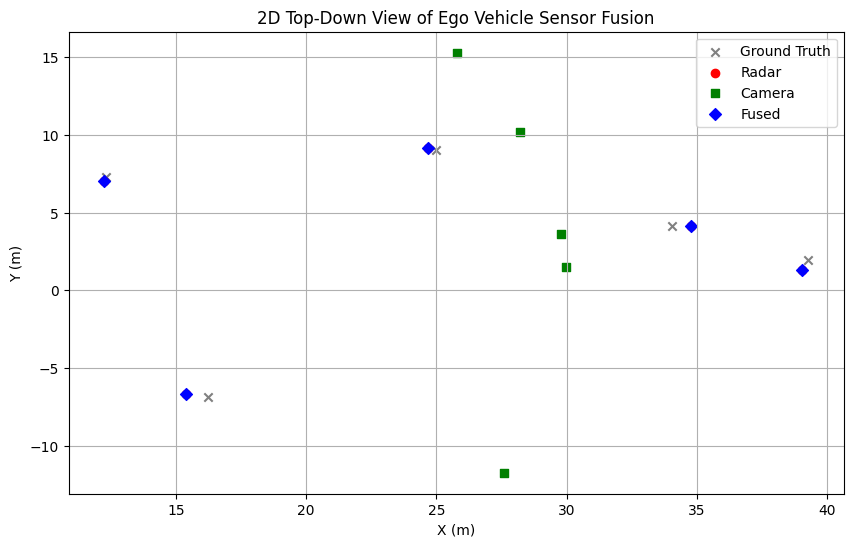

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate synthetic radar and camera data
def generate_synthetic_data(num_objects=5):
    np.random.seed(42)
    # Ground truth positions (x, y) in meters of objects in front of the ego vehicle
    positions = np.random.uniform(low=[10, -10], high=[50, 10], size=(num_objects, 2))

    radar_data = []
    for i, (x, y) in enumerate(positions):
        # Simulate radar range and angle measurements with noise
        rng = np.sqrt(x**2 + y**2) + np.random.normal(0, 0.5)
        angle = np.degrees(np.arctan2(y, x)) + np.random.normal(0, 1)
        velocity = np.random.uniform(-5, 5)  # Simulated radial velocity
        radar_data.append({"id": f"r{i}", "range": rng, "angle": angle, "velocity": velocity})

    camera_data = []
    for i, (x, y) in enumerate(positions):
        # Estimate angle from object position
        angle = np.degrees(np.arctan2(y, x))
        # Map angle to pixel x-coordinate assuming linear projection and 90-degree FOV
        pixel_x = int((angle + 45) * (640 / 90))
        bbox = [pixel_x - 10, 100, pixel_x + 10, 200]  # Simulated bounding box in pixel space
        camera_data.append({"id": i, "bbox": bbox, "class": "car"})

    return positions, radar_data, camera_data

# Step 2: Fuse radar and camera detections based on angle/pixel proximity
def fuse_sensors(radar_data, camera_data, cam_fov=90, img_width=640):
    fused = []

    for radar in radar_data:
        # Convert radar angle to camera pixel x-coordinate
        radar_px = int((radar['angle'] + cam_fov / 2) * (img_width / cam_fov))

        # Try to find the closest camera detection in pixel space
        min_dist = float('inf')
        matched = None
        for cam in camera_data:
            bbox_cx = (cam['bbox'][0] + cam['bbox'][2]) // 2  # Center x of bounding box
            if abs(bbox_cx - radar_px) < min_dist and abs(bbox_cx - radar_px) < 30:
                min_dist = abs(bbox_cx - radar_px)
                matched = cam

        # Convert polar to Cartesian coordinates (x, y)
        angle_rad = np.radians(radar['angle'])
        x = radar['range'] * np.cos(angle_rad)
        y = radar['range'] * np.sin(angle_rad)

        # Build fused object data
        fused_obj = {
            "x": x,
            "y": y,
            "velocity": radar['velocity'],
            "source": ["radar", "camera"] if matched else ["radar"]
        }

        fused.append(fused_obj)

    return fused

# Step 3: Visualize ground truth, radar, camera, and fused objects
def plot_fused_objects(gt_positions, radar_data, camera_data, fused_objects):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title("2D Top-Down View of Ego Vehicle Sensor Fusion")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.grid(True)

    # Plot ground truth positions (in gray)
    ax.scatter(gt_positions[:, 0], gt_positions[:, 1], c='gray', label='Ground Truth', marker='x')

    # Plot radar detections (in red)
    for r in radar_data:
        angle_rad = np.radians(r['angle'])
        x = r['range'] * np.cos(angle_rad)
        y = r['range'] * np.sin(angle_rad)
        ax.scatter(x, y, c='red', label='Radar', marker='o')

    # Plot camera detections (in green)
    for cam in camera_data:
        angle = ((cam['bbox'][0] + cam['bbox'][2]) // 2) * (90 / 640) - 45  # Convert pixel back to angle
        range_est = 30  # Assume fixed distance for plotting
        angle_rad = np.radians(angle)
        x = range_est * np.cos(angle_rad)
        y = range_est * np.sin(angle_rad)
        ax.scatter(x, y, c='green', label='Camera', marker='s')

    # Plot fused detections (in blue)
    for f in fused_objects:
        ax.scatter(f['x'], f['y'], c='blue', marker='D', label='Fused')

    # Ensure legend entries are unique
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

# Step 4: Run the simulation
if __name__ == "__main__":
    # Generate synthetic object positions and sensor data
    gt_positions, radar_data, camera_data = generate_synthetic_data()
    # Fuse radar and camera sensor outputs
    fused_objects = fuse_sensors(radar_data, camera_data)
    # Visualize the results
    plot_fused_objects(gt_positions, radar_data, camera_data, fused_objects)